In [324]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn

import matplotlib.pyplot as plt

# импортируем трансформеры
import transformers
import warnings
warnings.filterwarnings('ignore')


In [325]:
df = pd.read_csv('data/labeled.csv')

In [326]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [327]:
import re
import string
from collections import Counter

from nltk.corpus import stopwords

stop_words = set(stopwords.words("russian"))

def data_preprocessing(text: str) -> str:
    """preprocessing string: lowercase, removing html-tags, punctuation and stopwords

    Args:
        text (str): input string for preprocessing

    Returns:
        str: preprocessed string
    """

    text = text.lower()
    text = re.sub("<.*?>", "", text)  # html tags
    text = "".join([c for c in text if c not in string.punctuation])
    splitted_text = [word for word in text.split() if word not in stop_words]
    text = " ".join(splitted_text)
    return text


df["comment"] = df["comment"].apply(data_preprocessing)
df.head()

,comment,toxic
0,верблюдовто дебилы бл,1.0
1,хохлы это отдушина затюканого россиянина мол в...,1.0
2,собаке собачья смерть,1.0
3,страницу обнови дебил это оскорбление доказанн...,1.0
4,убедил 6страничный пдф скрипалей отравила росс...,1.0


In [328]:
review_len = [len(text) for text in df['comment']]
df['Review len'] = review_len
df.head()

,comment,toxic,Review len
0,верблюдовто дебилы бл,1.0,21
1,хохлы это отдушина затюканого россиянина мол в...,1.0,83
2,собаке собачья смерть,1.0,21
3,страницу обнови дебил это оскорбление доказанн...,1.0,123
4,убедил 6страничный пдф скрипалей отравила росс...,1.0,86


In [329]:
print(df['Review len'].describe())

count    14412.000000
mean       133.618998
std        217.317922
min          0.000000
25%         41.000000
50%         75.000000
75%        147.000000
max       6229.000000
Name: Review len, dtype: float64


In [330]:
device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

# 1.TOKENIZER

In [331]:
import torch
from transformers import AutoTokenizer, AutoModel

model_checkpoint = 'cointegrated/rubert-tiny-toxicity'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint)

In [332]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


In [333]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment"].tolist(), df["toxic"].tolist(), test_size=0.2, random_state=42
)

train_df = pd.DataFrame({
    "comment": train_texts,
    "toxic": train_labels
})

val_df = pd.DataFrame({
    "comment": val_texts,
    "toxic": val_labels
})

In [334]:
train_df

,comment,toxic
0,последнюю серию специально смотрю сериал закон...,0.0
1,это тяжёлая работа ктото должен её делать,0.0
2,рецептурные вообще названий самое известное эт...,0.0
3,горные обезьяны это типа киргизы,1.0
4,холодильнике хранился завонял просто половину ...,0.0
...,...,...
11524,знаю откуда машин столько людей районы новые с...,0.0
11525,кандидатка завалилась электрохромизме могут тв...,1.0
11526,второй сезон полная хуета,0.0
11527,мда хотел просто спасибо сказать какуюто обиже...,1.0


In [335]:
SEQ_LEN = 150

train_encoded_messages = train_df['comment'].apply(
    lambda x: tokenizer(x, max_length=SEQ_LEN, truncation=True, padding='max_length')
).values

val_encoded_messages = val_df['comment'].apply(
    lambda x: tokenizer(x, max_length=SEQ_LEN, truncation=True, padding='max_length')
).values

In [336]:
train_encoded_messages[2]

{'input_ids': [2, 328, 4225, 9438, 14033, 1308, 24681, 24570, 29076, 12923, 626, 2389, 6500, 638, 981, 6500, 638, 981, 2389, 29231, 4318, 1023, 1619, 17045, 10672, 26941, 7278, 10365, 626, 28032, 721, 10543, 589, 9745, 1888, 6222, 13305, 16890, 21418, 4636, 10750, 3272, 26335, 13011, 1967, 2225, 12666, 20806, 4550, 10861, 28009, 5571, 19860, 22239, 24530, 16495, 1395, 18503, 1736, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [337]:
# 2.LabelEncoding
le = LabelEncoder()

train_labels = le.fit_transform(train_df['toxic'])
val_labels = le.fit_transform(val_df['toxic'])
NUMBER_OF_CLASSES = len(np.unique(train_labels))
NUMBER_OF_CLASSES

2

In [338]:
train_labels

array([0, 0, 0, ..., 0, 1, 0])

In [339]:
# 3. BertInputs (DATASET)
class BertInputs(torch.utils.data.Dataset):
    def __init__(self, encoded_messages, labels, device='mps'):
        super().__init__()
        self.inputs = encoded_messages
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.inputs[idx]['input_ids'], device=self.device).long()
        attention_mask = torch.tensor(self.inputs[idx]['attention_mask'], device=self.device).long()
        label = torch.tensor(self.labels[idx], device=self.device).long()

        return input_ids, attention_mask, label


train_dataset = BertInputs(train_encoded_messages, train_labels, device=device)
val_dataset = BertInputs(val_encoded_messages, val_labels, device=device)

# Извлечение одного примера
test_ids, test_mask, test_label = train_dataset[2]


test_ids, test_mask, test_label

(tensor([    2,   328,  4225,  9438, 14033,  1308, 24681, 24570, 29076, 12923,
           626,  2389,  6500,   638,   981,  6500,   638,   981,  2389, 29231,
          4318,  1023,  1619, 17045, 10672, 26941,  7278, 10365,   626, 28032,
           721, 10543,   589,  9745,  1888,  6222, 13305, 16890, 21418,  4636,
         10750,  3272, 26335, 13011,  1967,  2225, 12666, 20806,  4550, 10861,
         28009,  5571, 19860, 22239, 24530, 16495,  1395, 18503,  1736,     3,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [340]:
# 4. DATALOADER
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [341]:
class MyToxicBERT(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        for param in self.model.parameters():
            param.requires_grad = False
        self.linear = nn.Sequential(
            nn.Linear(312, 256),
            nn.Dropout(),
            nn.Linear(256, 1),
        )

    def forward(self, input_ids, attention_mask):
        # Получаем скрытые состояния от базовой модели
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Используем `last_hidden_state` для CLS токена
        hidden_states = outputs.last_hidden_state  # Скрытые состояния
        cls_token = hidden_states[:, 0, :]  # Первый токен для CLS
        
        # Пропускаем через линейный слой, чтобы получить логиты
        logits = self.linear(cls_token)
        return logits
    
	

In [342]:
my_model = MyToxicBERT(model)
my_model.to(device)

MyToxicBERT(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_af

In [343]:
input_ids, attention_mask, labels = next(iter(train_loader))
outputs = my_model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device))
print(outputs.shape)  # Должен быть размер (batch_size, 1)

torch.Size([64, 1])


In [344]:
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from time import time
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(my_model.linear.parameters(), lr=0.005)

In [345]:
def train(
        epochs: int,
        model: torch.nn.Module,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        criterion,
        metric,
        device: torch.device
        ) -> tuple:
    """Training BERT model for multi-class classification task

    Args:
        epochs (int): Number of epochs
        model (nn.Module): Model instance
        train_loader (DataLoader): train loader
        valid_loader (DataLoader): valid loader
        optimizer (torch.optim.Optimizer): optimizer
        criterion (nn.Module): criterion
        metric (_type_): metric from torchmetrics
        device (torch.device): device to train on (cpu or cuda)

    Returns:
        tuple: (train loss, valid loss, train metric, valid metric, training_time)
    """
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_train_metric = []
    epoch_valid_metric = []
    time_start = time()

    for epoch in range(epochs):
        batch_losses = []
        batch_metric = []
        model.train()
        model.to(device)

        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            labels = labels.unsqueeze(1).float()  # Добавляем размерность для соответствия выходу модели
				
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_metric.append(f1_score(labels.cpu(), outputs.argmax(1).cpu(), average='weighted'))

        epoch_train_losses.append(np.mean(batch_losses))
        epoch_train_metric.append(np.mean(batch_metric))

        batch_losses = []
        batch_metric = []
        model.eval()

        with torch.no_grad():
            for input_ids, attention_mask, labels in valid_loader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
                labels = labels.unsqueeze(1).float()  # Добавляем размерность для соответствия выходу модели

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                batch_losses.append(loss.item())
                batch_metric.append(f1_score(labels.cpu(), outputs.argmax(1).cpu(), average='weighted'))

        epoch_valid_losses.append(np.mean(batch_losses))
        epoch_valid_metric.append(np.mean(batch_metric))

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {epoch_train_losses[-1]:.4f} | Val Loss: {epoch_valid_losses[-1]:.4f}')
        print(f'Train F1 Score: {epoch_train_metric[-1]:.4f} | Val F1 Score: {epoch_valid_metric[-1]:.4f}')
        print(25 * '==')

    training_time = time() - time_start
    return epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, training_time

In [346]:
# Обучение модели
train_losses, val_losses, train_f1, val_f1, training_time = train(
    epochs=20,
    model=my_model,
    train_loader=train_loader,
    valid_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    metric=f1_score,
    device=device
)

Epoch 1/20
Train Loss: 0.3962 | Val Loss: 0.3306
Train F1 Score: 0.5290 | Val F1 Score: 0.5444
Epoch 2/20
Train Loss: 0.3799 | Val Loss: 0.3059
Train F1 Score: 0.5305 | Val F1 Score: 0.5536
Epoch 3/20
Train Loss: 0.3757 | Val Loss: 0.2959
Train F1 Score: 0.5294 | Val F1 Score: 0.5444
Epoch 4/20
Train Loss: 0.3742 | Val Loss: 0.3522
Train F1 Score: 0.5315 | Val F1 Score: 0.5446
Epoch 5/20
Train Loss: 0.3846 | Val Loss: 0.2818
Train F1 Score: 0.5306 | Val F1 Score: 0.5537
Epoch 6/20
Train Loss: 0.3859 | Val Loss: 0.3119
Train F1 Score: 0.5306 | Val F1 Score: 0.5366
Epoch 7/20
Train Loss: 0.3787 | Val Loss: 0.3547
Train F1 Score: 0.5295 | Val F1 Score: 0.5367
Epoch 8/20
Train Loss: 0.3884 | Val Loss: 0.3104
Train F1 Score: 0.5308 | Val F1 Score: 0.5544
Epoch 9/20
Train Loss: 0.3926 | Val Loss: 0.3426
Train F1 Score: 0.5298 | Val F1 Score: 0.5368
Epoch 10/20
Train Loss: 0.3893 | Val Loss: 0.2928
Train F1 Score: 0.5300 | Val F1 Score: 0.5367
Epoch 11/20
Train Loss: 0.3800 | Val Loss: 0.3208

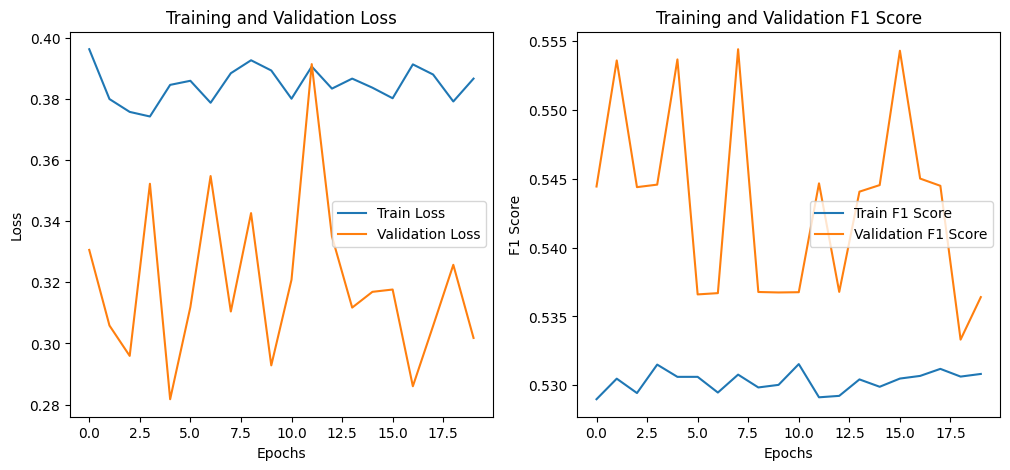

In [347]:
# Отрисовка графиков
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(20), train_losses, label='Train Loss')
plt.plot(range(20), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(20), train_f1, label='Train F1 Score')
plt.plot(range(20), val_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Training and Validation F1 Score')

plt.show()

In [348]:
# Сохранение весов модели
torch.save(my_model.state_dict(), 'model.pth')